In [3]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from datetime import timedelta
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)  # Show all columns


# Function to convert MM:SS to seconds, handling NaN values
def mmss_to_seconds(mmss):
    mmss = str(mmss)  # Ensure mmss is a string
    if pd.isna(mmss):
        return np.nan  # Return NaN if the value is NaN
    else:
        minutes, seconds = map(int, mmss.split(':'))
        return minutes * 60 + seconds

# Function to convert total seconds to MM:SS format
def mmss_to_seconds(mmss):
    try:
        if isinstance(mmss, str) and ':' in mmss:
            minutes, seconds = map(int, mmss.split(':'))
            return minutes * 60 + seconds
        elif mmss == '0' or mmss == 0 or pd.isna(mmss):
            return 0
    except Exception:
        pass
    return 0  # fallback if bad format

In [4]:
# load player data
player_data = pd.read_csv("C:/users/conno/OneDrive/Documents/Personal-and-NHL-Website/public_html/resources/data/nhl_players.csv")
player_data = player_data.fillna(0)

# Load pbp data
pbp_data = pd.read_csv("C:/users/conno/OneDrive/Documents/Personal-and-NHL-Website/public_html/resources/data/nhl_plays.csv")
pbp_data = pbp_data.fillna(0).sort_values(by=['gameID', 'eventID'])

# merge shooter data
pbp_w_shooter_data = pd.merge(pbp_data, player_data[['playerId', 'shootsCatches', 'draftOverall', 'regSeasonCareerShootingPct']], how='left', left_on='shootingPlayerId', right_on='playerId', suffixes=('', '_shooter'))

# merge goalie data
pbp_full = pd.merge(pbp_w_shooter_data, player_data[['playerId', 'shootsCatches', 'draftOverall', 'regSeasonCareerSavePct']], how='left', left_on='goalieInNetId', right_on='playerId', suffixes=('', '_goalie'))

# Optional: drop extra playerId columns if you want
pbp = pbp_full.drop(columns=['playerId', 'playerId_goalie'])

pbp.to_csv("C:/Users/conno/OneDrive/Documents/Personal-and-NHL-Website/public_html/resources/data/nhl_plays_with_players.csv", index=False)

# Preview the merged data
print(pbp.head())


C:\Users\conno\AppData\Local\Temp\ipykernel_29524\1148201181.py:2: DtypeWarning: Columns (1,2,7,11,12,13,14,20,22,23,24,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,66,68,69,70,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,90,91,92,93,94,95,96,98,99,100,101,102,103,104,105,106) have mixed types. Specify dtype option on import or set low_memory=False.
  player_data = pd.read_csv("C:/users/conno/OneDrive/Documents/Personal-and-NHL-Website/public_html/resources/data/nhl_players.csv")
C:\Users\conno\AppData\Local\Temp\ipykernel_29524\1148201181.py:6: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  pbp_data = pd.read_csv("C:/users/conno/OneDrive/Documents/Personal-and-NHL-Website/public_html/resources/data/nhl_plays.csv")


       gameID   eventID  period timeInPeriod timeRemaining  situationCode  \
0  2001021074  10634706       1     12:25:00      07:35:00              0   
1  2001021074  10634707       1     14:21:00      05:39:00              0   
2  2001021074  10634708       1     14:45:00      05:15:00              0   
3  2001021074  10634709       1     15:34:00      04:26:00              0   
4  2001021074  10634710       1     17:25:00      02:35:00              0   

   typeCode   typeDescKey  xCoord  yCoord  zoneCode  eventOwnerTeamId  \
0       506  shot-on-goal       0       0         0                14   
1       506  shot-on-goal       0       0         0                 6   
2       506  shot-on-goal       0       0         0                 6   
3       506  shot-on-goal       0       0         0                 6   
4       506  shot-on-goal       0       0         0                 6   

   faceoffLoserId  faceoffWinnerId  hittingPlayerId  hitteePlayerId shotType  \
0               0 

In [5]:
# Target variable: 1 for goal, 0 for non-goal
pbp_data['goal'] = np.where(pbp_data['typeDescKey'] == 'goal', 1, 0)


### Feature engineering ###

left_net_xCoord = -89.0
right_net_xCoord = 89.0
left_net_yCoord = 0.0
right_net_yCoord = 0.0

# Remove bad rows
pbp_data = pbp_data[pbp_data['xCoord'] != 'No data available']
pbp_data = pbp_data[pbp_data['yCoord'] != 'No data available']

# Convert types
pbp_data['xCoord'] = pbp_data['xCoord'].astype(float)
pbp_data['yCoord'] = pbp_data['yCoord'].astype(float)
pbp_data['duration'] = pbp_data['duration'].astype(float)  # Convert to float first if needed
# data['duration'] = data['duration'].astype(int)

# Distances - correctly written
pbp_data['distance_from_left_net'] = np.sqrt((pbp_data['xCoord'] - left_net_xCoord)**2 + (pbp_data['yCoord'] - left_net_yCoord)**2)
pbp_data['distance_from_right_net'] = np.sqrt((pbp_data['xCoord'] - right_net_xCoord)**2 + (pbp_data['yCoord'] - right_net_yCoord)**2)

# Pick the correct distance depending on side defending - NEED TO CHANGE THIS,IT'S ALWAYS ASSUMING HOME TEAM IS SHOOTING
pbp_data['relevant_distance'] = np.where(
    pbp_data['homeTeamDefendingSide'] == 'left',
    pbp_data['distance_from_left_net'],
    np.where(
        pbp_data['homeTeamDefendingSide'] == 'right',
        pbp_data['distance_from_right_net'],
        np.nan  # if missing or weird value
    )
)

# Also calculate "relevant_angle_num" safely
pbp_data['relevant_angle_num'] = np.where(
    pbp_data['homeTeamDefendingSide'] == 'left',
    pbp_data['xCoord'] - (-89),
    np.where(
        pbp_data['homeTeamDefendingSide'] == 'right',
        89 - pbp_data['xCoord'],
        np.nan
    )
)

# Get distance features
pbp_data['distance'] = pbp_data['relevant_distance']
pbp_data['angle'] = np.arccos(pbp_data['relevant_angle_num'] / pbp_data['relevant_distance'])
pbp_data['log_distance'] = np.log1p(pbp_data['distance'])  # log transform
pbp_data['sin_angle'] = np.sin(pbp_data['angle'])          # sin of angle

pbp_data['homeTeamDefendingSide'] = pbp_data['homeTeamDefendingSide'].map({'left': 0, 'right': 1})

# Get type of previous event
pbp_data = pbp_data.sort_values(by=['gameID', 'eventID'])  # Use appropriate column name for event order
pbp_data['prev_typeDescKey'] = pbp_data.groupby('gameID')['typeDescKey'].shift(1)  # Shift within each game
print(pbp_data['prev_typeDescKey'])

# create specific feature for rebound
pbp_data['rebound'] = np.where(pbp_data['prev_typeDescKey'] == 'shot', 1, 0)

pbp_data['timeRemaining'] = pbp_data['timeRemaining'].apply(mmss_to_seconds)  # Convert to seconds, leave as string so formatting works

# Strength state of game (5v5, 4v4, etc.)
pbp_data['penaltyStartTime'] = np.where(pbp_data['duration'].notnull(), pbp_data['timeRemaining'], np.nan)
pbp_data['penaltyEndTime'] = np.where(pbp_data['duration'].notnull(), pbp_data['timeRemaining'] - pbp_data['duration'], np.nan)
pbp_data['penalty_active'] = (pbp_data['timeRemaining'] >= pbp_data['penaltyStartTime']) & (pbp_data['timeRemaining'] <= pbp_data['penaltyEndTime'])



# Function to adjust penalty based on goal logic
def adjust_penalty_based_on_goal(row, last_goal_time):
    # If a goal is scored
    if row['goal'] == 1:
        # Case 1: 2-minute penalty duration should become inactive after a goal
        if row['duration'] == 2:
            return False  # Penalty is no longer active
        
        # Case 2: 5-minute penalty duration remains active after a goal
        elif row['duration'] == 5:
            return True  # Penalty remains active
        
        # Case 3: 4-minute penalty logic based on when the goal occurs
        elif row['duration'] == 4:
            if row['timeRemaining'] >= 2:  # Goal scored within first 2 minutes
                return True  # Penalty resets to 2 minutes starting from goal
            else:  # Goal scored after 2 minutes
                return False  # Penalty ends

    # If no goal was scored, the penalty stays active as long as timeRemaining is positive
    if row['timeRemaining'] > 0:
        return True  # Penalty is still active
    
    return False  # Penalty is not active

# Apply logic to adjust penalty active-ness based on goal events
last_goal_time = None  # Track the last goal time
pbp_data['penalty_active'] = False  # Initialize the column for tracking penalty active-ness

for idx, row in pbp_data.iterrows():
    # Update the penalty_active status based on the goal
    pbp_data.at[idx, 'penalty_active'] = adjust_penalty_based_on_goal(row, last_goal_time)
    
    # If a goal is scored, update the last goal time (this will allow us to track when the goal happens)
    if row['goal'] == 1:
        last_goal_time = row['timeRemaining']  # Set the goal time

# After this, you can reassign the strength column based on the adjusted penalty status
pbp_data['strength'] = pbp_data['penalty_active'].apply(lambda x: 'PK' if x else 'EV')

pbp_data['penaltyType'] = np.where(pbp_data['penaltyType'], 1, 0)




# time of event before/time betweend events
# player skill (shot pct)
# distance between prev event and current (could indicate pass)

# One hot encoding for categorical variables
for col in ['typeDescKey', 'shotType', 'penaltyType', 'prev_typeDescKey', 'strength']:
    if col in pbp_data.columns:
        pbp_data = pd.get_dummies(pbp_data, columns=[col], drop_first=True)
    else:
        print(f"{col} not found in data")


# Features 'shotType_backhand',
features = ['xCoord', 'yCoord', 'homeTeamDefendingSide', 'distance', 'angle', 'shotType_wrist', 'shotType_snap', 'shotType_slap',  'shotType_tip-in', 'shotType_wrap-around', 
            'log_distance', 'sin_angle'] + \
           [col for col in pbp_data.columns if col.startswith('prev_typeDescKey')]  # Add the one-hot encoded columns dynamically
missing_columns = [col for col in features if col not in pbp_data.columns]
print("Missing columns:", missing_columns)

0                   NaN
1          shot-on-goal
2          shot-on-goal
3          shot-on-goal
4          shot-on-goal
               ...     
1094983    shot-on-goal
1094984             hit
1094985        stoppage
1094986    blocked-shot
1094987         faceoff
Name: prev_typeDescKey, Length: 1094988, dtype: object
Missing columns: []


In [6]:
X = pbp_data[features]
y = pbp_data['goal']

print(X.head(10))
print(X.describe())
print(X.sample(1))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

   xCoord  yCoord  homeTeamDefendingSide  distance  angle  shotType_wrist  \
0     0.0     0.0                    NaN       NaN    NaN           False   
1     0.0     0.0                    NaN       NaN    NaN           False   
2     0.0     0.0                    NaN       NaN    NaN            True   
3     0.0     0.0                    NaN       NaN    NaN            True   
4     0.0     0.0                    NaN       NaN    NaN           False   
5     0.0     0.0                    NaN       NaN    NaN           False   
6     0.0     0.0                    NaN       NaN    NaN            True   
7     0.0     0.0                    NaN       NaN    NaN           False   
8     0.0     0.0                    NaN       NaN    NaN           False   
9     0.0     0.0                    NaN       NaN    NaN            True   

   shotType_snap  shotType_slap  shotType_tip-in  shotType_wrap-around  \
0          False           True            False                 False   
1   

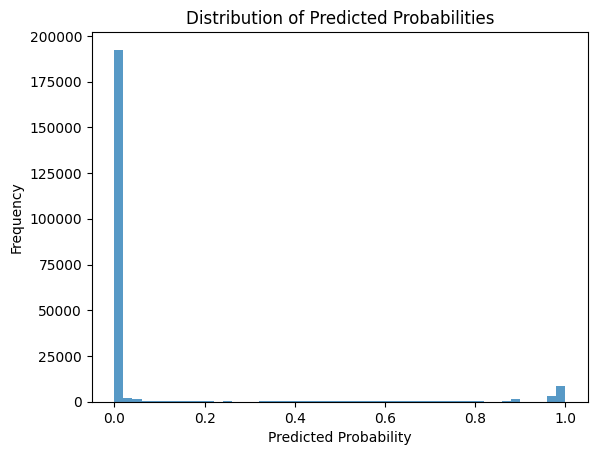

Accuracy: 0.9545931926318962
ROC-AUC: 0.9326392004910915
[[199450   8383]
 [  1561   9604]]
              precision    recall  f1-score   support

           0       0.99      0.96      0.98    207833
           1       0.53      0.86      0.66     11165

    accuracy                           0.95    218998
   macro avg       0.76      0.91      0.82    218998
weighted avg       0.97      0.95      0.96    218998



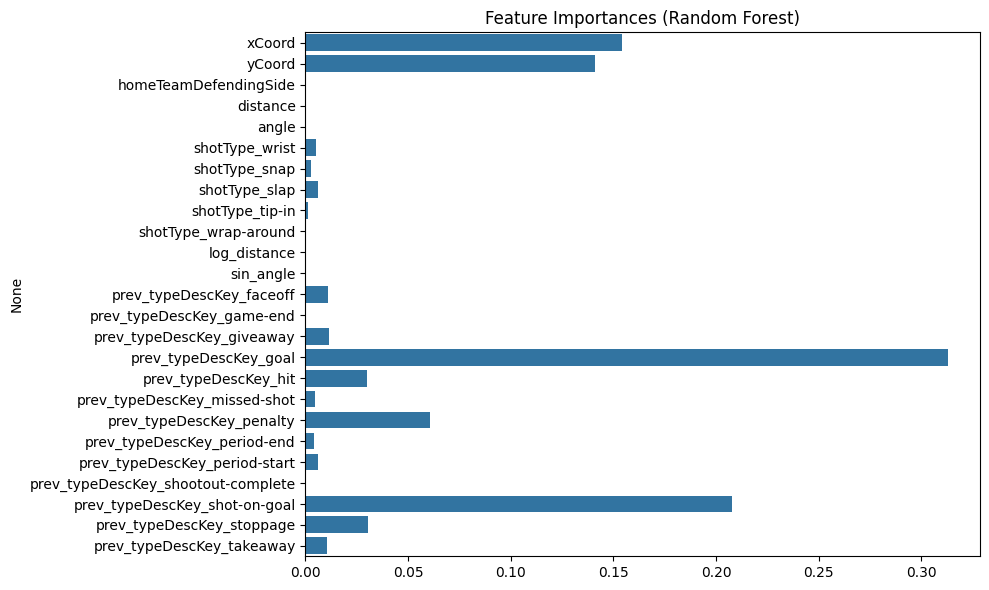

In [7]:
####################################################################### RANDOM FOREST CLASSIFIER #######################################################################

model_rf = RandomForestClassifier(class_weight='balanced', random_state=42)
model_rf.fit(X_train, y_train)

# Predictions
y_pred_rf = model_rf.predict(X_test)
y_pred_prob_rf = model_rf.predict_proba(X_test)[:, 1]

# Adjust the threshold for classification
threshold = 0.1
y_pred = (y_pred_prob_rf >= threshold).astype(int)


# Plot the distribution of predicted probabilities
plt.hist(y_pred_prob_rf, bins=50, range=(0, 1), alpha=0.75)
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_prob_rf))
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


importances = model_rf.feature_importances_
feat_names = X.columns
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feat_names)
plt.title("Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()